In [1]:
## helpful packages
import pandas as pd
import numpy as np
import random
import re
import recordlinkage
from sklearn.feature_extraction.text import TfidfVectorizer
## nltk imports
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
# ! pip install xlrd
# ! pip install openpyxl
## lda 
from gensim import corpora
import gensim
import matplotlib.pyplot as plt # rj note- this import was mssing from the script

## repeated printouts
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## define constants and pathnames
GITHUB_DATA_PATH = "../data/"
DROPBOX_DATA_PATH = "../../../qss20_finalproj_rawdata/textasdata/"
COMBINED_DISCLOSURE_DATA = "H-2A_Disclosure_Data_FY_combined_202021Q1.csv"
COMBINED_ADDENDUMS_DATA = "FOIA_2021-F-05932_raw_data_combined_202021Q1.csv"

# Load datasets

In [2]:
# load data
addendum = pd.read_csv(DROPBOX_DATA_PATH + COMBINED_ADDENDUMS_DATA)
disclosure = pd.read_csv (DROPBOX_DATA_PATH + COMBINED_DISCLOSURE_DATA)

/Users/rebeccajohnson/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (17,18,31,83,84,138,139) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# 1. Aggregate addendums data

- Dropping duplicates
- Joining free text
- Removing ones with Spanish

In [3]:
print("Before dropping duplicates, %s rows" % len(addendum))
addendum = addendum.drop_duplicates(["CASE_NUMBER", "SECTION_DETAILS"])
print("After dropping duplicates, %s rows" % len(addendum))

Before dropping duplicates, 102317 rows
After dropping duplicates, 99620 rows


In [4]:
addendum_agg = addendum.groupby(['CASE_NUMBER'])['SECTION_DETAILS'].apply(lambda text: ''.join(text.to_string(index=False))).str.replace('(\\n)', '').reset_index()
print("After pasting together addendums from same case, %s rows" % len(addendum_agg))
assert len(addendum_agg) == len(addendum.CASE_NUMBER.unique())

After pasting together addendums from same case, 13535 rows


<ipython-input-4-07beded20aeb>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  addendum_agg = addendum.groupby(['CASE_NUMBER'])['SECTION_DETAILS'].apply(lambda text: ''.join(text.to_string(index=False))).str.replace('(\\n)', '').reset_index()


In [5]:
## Above code modified from fifth answer at https://stackoverflow.com/questions/27298178/concatenate-strings-from-several-rows-using-pandas-groupby
## because original groupby was including a bunch of linebreaks

In [6]:
# Rename Columns in aggregated addendums
addendum_agg = addendum_agg.rename(columns = {"SECTION_DETAILS":"JOB_DESCRIPTION"})

In [7]:
#Remove Job Listings that Contain Spanish Words
spanish_words = ['compensación',
 'ocupación',
 'pago',
 'transporte',
 'reglas',
 'contrato',
 'horastrabajadores',
 'parte',
 'tarifas',
 'cuartos',
 'trabajo',
 'registros',
 'adicionales',
 'comidas',
 'empleo',
 'terminación',
 'vivienda',
 'empleador',
 'adicionales',
 'frecuencia',
 'producción',
 'liquidación',
 'comida',
 'herramientas',
 'prueba',
 'diaria',
 'tarifas',
 'parado',
 'adicionales',
 'cobertura',
 'proporcionados',
 'parte',
 'abandono',
 'deducciones',
 'causa',
 'garantías',
 'divulgación',
 'comidas',
 'política',
 'disciplina',
 'despidos',
 'derechos',
 'imposibilidad',
 'detalles',
 'divulgación',
 'bloqueo',
 'abandono',
 'ganancias',
 'cobertura',
 'pedidos',
 'pago',
 'oportunidad',
 'trabajo']


## rj note: not high priority, but i have some concerns about doing this 
## removal on the aggregated addendums rather than the sections
## in particular, it might make more sense to do the spanish indicator on whether a specific section
## contains spanish and then remove that section; preserving non-spanish sections of that posting
## this discards the whole post if any section contains spanish, which ends up deleting more data
addendum_agg['is_contains_spanish'] = np.where(addendum_agg.JOB_DESCRIPTION.str.contains('|'.join(spanish_words)),
                                              True, False)

addendum_eng = addendum_agg[~addendum_agg.is_contains_spanish].copy()
print("Removing addendums with any spanish takes us from {} jobs to {} jobs".format(
        len(addendum_agg.CASE_NUMBER.unique()),
        len(addendum_eng.CASE_NUMBER.unique())))


Removing addendums with any spanish takes us from 13535 jobs to 11763 jobs


# Merge the addendums data to disclosure data

- Clean up state in the disclosure data
- Create indicate for TRLA catchment area
- Create diff merges

RJ note: originally, this had a lot of stuff related to the disclosure data but since we're doing a left join of addendums onto disclosures, and comparing jobs in two categories---"left only" (disclosure with no addendum) and "both" (disclosure with addendum)---we can delete most of the disclosure stuff post merge and just use left-joined df

In [8]:
#Make Sure all the rows under EMPLOYER_STATE has two digit state code
disclosure['EMPLOYER_STATE'] =disclosure.EMPLOYER_STATE.astype("string")
disclosure.loc[disclosure.EMPLOYER_STATE.isnull(),
          ['EMPLOYER_STATE', 'EMPLOYER_CITY', 'EMPLOYER_ADDRESS_1',
          'EMPLOYER_ADDRESS_2', 'EMPLOYER_POC_STATE']].sample(n = 10, random_state = 444)

## rj note: might want to consider allowing employer_poc_state to count
## as state but left as is
## i left in ones with missing states and they're just false for TRLA catchment


,EMPLOYER_STATE,EMPLOYER_CITY,EMPLOYER_ADDRESS_1,EMPLOYER_ADDRESS_2,EMPLOYER_POC_STATE
6187,<NA>,Coaldale,Box 1298,NaN,CA
4555,<NA>,Quill Lake,PO Box 634,NaN,NaN
5602,<NA>,Lethbridge,1510 C 31 Street North,NaN,NaN
3802,<NA>,Hodgeville,Highway 19 South,Box 127,NaN
5498,<NA>,Fort Macleod,146 Manning Ave,NaN,NaN
3369,<NA>,Craik,Box 222,NaN,NaN
12479,<NA>,Cairo,1511 Ridge Road,NaN,GA
5289,<NA>,hargeisa,hargeisa somaliland,Mohamed haybe,NaN
4706,<NA>,Foremost,602 Center Street,NaN,NaN
8790,<NA>,Deloraine,Box 850,NaN,ND


In [9]:
# Label TRLA Catchment State VS Remaining States
## rj note- isin more efficient than long or chain
TRLA_catchment = ["TX", "MS", "AL", "TN", "KY", "LA"]
disclosure["TRLA"] = np.where(disclosure.EMPLOYER_STATE.isin(TRLA_catchment), True, False)
disclosure.TRLA.value_counts(normalize = True)

False    0.713937
True     0.286063
Name: TRLA, dtype: float64

In [10]:
## left join addendums onto disclosures 
## using case number
## rj note- i'm just merging english addendums (addendum_eng)
## to keep code consistent but you may want to add back
## the spanish ones (addendum_agg)
merged_data_left = pd.merge(disclosure,
                             addendum_eng,
                             left_on = 'CASE_NUMBER',
                             right_on = 'CASE_NUMBER',
                             how = "left",
                             indicator = "case_merge_status")
merged_data_left.case_merge_status.value_counts()

both          11756
left_only      5027
right_only        0
Name: case_merge_status, dtype: int64

# Diagnostics of ones with and without english addendums

In [11]:
## rj note: i cleaned this up to just use the full left join
merged_data_left[['ANTICIPATED_NUMBER_OF_HOURS', 'WAGE_OFFER', 'TOTAL_WORKERS_NEEDED']].dtypes

## rj note; combining data w/ code rather than excel
## kept this as float rather than as string ($) might have been an 
## excel formatting thing so kept this code in case issue reoccurs
## but probally fine to delete:
if merged_data_left.dtypes['WAGE_OFFER'] != "float64":
      
    merged_data_left['WAGE_OFFER'] = merged_data_left['WAGE_OFFER'].str.replace('$', '')
    merged_data_left['WAGE_OFFER'] = merged_data_left['WAGE_OFFER'].str.replace(',', '')
    merged_data_left['WAGE_OFFER'] = merged_data_left['WAGE_OFFER'].astype(float)
        
merged_data_left[['ANTICIPATED_NUMBER_OF_HOURS', 'WAGE_OFFER', 'TOTAL_WORKERS_NEEDED']].dtypes

ANTICIPATED_NUMBER_OF_HOURS    float64
WAGE_OFFER                     float64
TOTAL_WORKERS_NEEDED           float64
dtype: object

ANTICIPATED_NUMBER_OF_HOURS    float64
WAGE_OFFER                     float64
TOTAL_WORKERS_NEEDED           float64
dtype: object

In [12]:
## add more informative column
merged_data_left['case_merge_status_descriptive'] = np.where(merged_data_left.case_merge_status == 
                                                        "left_only",
                                                        "No English addendum",
                                                        "English addendum")
merged_data_left.groupby('case_merge_status_descriptive').agg(
        {
         "WAGE_OFFER": ["median"],
         "TOTAL_WORKERS_NEEDED": ["median"],
        "ANTICIPATED_NUMBER_OF_HOURS": ["median"],
        "PIECE_RATE_OFFER": ["median"],
        "WORK_EXPERIENCE_MONTHS" : ["median"],
        "TOTAL_OCCUPANCY" : ["median"],
        "LIFTING_AMOUNT" : ["median"],
        "TRLA": np.mean} # rj note: added TRLA to hear since we can just take mean
        )

#percentage of non TRLA states is higher
#compare wages? is it that there's lower wage rate so there's no listing?


,WAGE_OFFER,TOTAL_WORKERS_NEEDED,ANTICIPATED_NUMBER_OF_HOURS,PIECE_RATE_OFFER,WORK_EXPERIENCE_MONTHS,TOTAL_OCCUPANCY,LIFTING_AMOUNT,TRLA
,median,median,median,median,median,median,median,mean
case_merge_status_descriptive,,,,,,,,
English addendum,13.62,6.0,40.0,0.0,3.0,8.0,60.0,0.296359
No English addendum,12.67,5.0,40.0,0.0,3.0,8.0,60.0,0.261985


## Plot breakdown of addendums by TRLA or not 

### Pie chart

In [13]:
merged_data_left.case_merge_status.value_counts()

both          11756
left_only      5027
right_only        0
Name: case_merge_status, dtype: int64

[3710, 1317]

[8272, 3484]

([<matplotlib.patches.Wedge at 0x7f8f7674c610>,
 [Text(-0.7479859598457378, 0.8065463432894916, 'Non-TRLA'),
  Text(0.747985884331416, -0.8065464133209879, 'TRLA')],
 [Text(-0.40799234173403875, 0.43993436906699535, '73.8%'),
  Text(0.40799230054440866, -0.4399344072659933, '26.2%')])

Text(0.5, 1.0, 'Jobs without English addendums\n(not in text analysis)')

Text(0.5, 1.0, 'Jobs with English addendums\n(in text analysis)')

([<matplotlib.patches.Wedge at 0x7f8f7675c490>,
 [Text(-0.6566997938979479, 0.8824655124674239, 'Non-TRLA'),
  Text(0.6566997938979482, -0.8824655124674237, 'TRLA')],
 [Text(-0.35819988758069876, 0.48134482498223113, '70.4%'),
  Text(0.358199887580699, -0.481344824982231, '29.6%')])

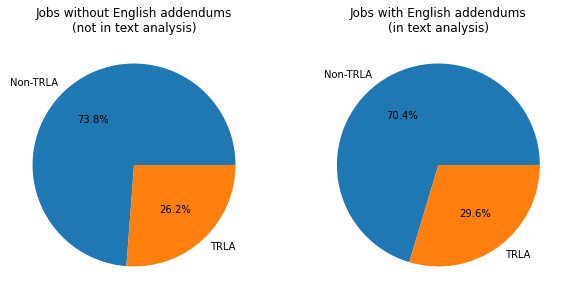

In [14]:
no_add = [merged_data_left[(merged_data_left.case_merge_status == "left_only") &
                     (~merged_data_left.TRLA)].shape[0],
            merged_data_left[(merged_data_left.case_merge_status == "left_only") &
                     (merged_data_left.TRLA)].shape[0]]
no_add

add = [merged_data_left[(merged_data_left.case_merge_status == "both") &
                     (~merged_data_left.TRLA)].shape[0],
            merged_data_left[(merged_data_left.case_merge_status == "both") &
                     (merged_data_left.TRLA)].shape[0]]
add
labels = ['Non-TRLA', 'TRLA'] 
fig, (plt1,plt2) = plt.subplots(1,2,figsize=(10,10))
plt1.pie(no_add, labels=labels, autopct='%1.1f%%')
plt1.set_title("Jobs without English addendums\n(not in text analysis)")
plt2.set_title("Jobs with English addendums\n(in text analysis)")
plt2.pie(add, labels=labels, autopct='%1.1f%%')

# Write outputs for next script

- pkl and csv (in case linebreak) of inner join between (1) disclosure and (2) aggregated, English-only addendums

In [17]:
## same join as above but inner join rather than left join
merged_data_inner = pd.merge(disclosure,
                             addendum_eng,
                             left_on = 'CASE_NUMBER',
                             right_on = 'CASE_NUMBER',
                             how = "inner")
merged_data_inner.shape

## write pkl and csv form to Dropbox folder
merged_data_inner.to_csv(DROPBOX_DATA_PATH + "merged_addendums_jobdisclosures.csv",
                        index = False)
merged_data_inner.to_pickle(DROPBOX_DATA_PATH + "merged_addendums_jobdisclosures.pkl")

(11756, 143)

In [15]:
## Older code - delete if i'm correct in discarding due to redundancy

# # ## look at one that doesnt have job listing
# merged_left_check=merged_data_left[merged_data_left.case_merge_status=="left_only"]
# merged_data[['ANTICIPATED_NUMBER_OF_HOURS', 'WAGE_OFFER', 'TOTAL_WORKERS_NEEDED']].dtypes
# merged_left_check[['ANTICIPATED_NUMBER_OF_HOURS', 'WAGE_OFFER', 'TOTAL_WORKERS_NEEDED']].dtypes
# merged_left_check['WAGE_OFFER'] = merged_left_check['WAGE_OFFER'].str.replace('$', '')
# merged_left_check['WAGE_OFFER'] = merged_left_check['WAGE_OFFER'].str.replace(',', '')
# merged_left_check['WAGE_OFFER'] = merged_left_check['WAGE_OFFER'].astype(float)
# #merged_data['WAGE_OFFER'] = merged_data['WAGE_OFFER'].str.replace('$', '')
# #merged_data['WAGE_OFFER'] = merged_data['WAGE_OFFER'].str.replace(',', '')
# #merged_data['WAGE_OFFER']= merged_data['WAGE_OFFER'].astype(float)
# merged_data[['ANTICIPATED_NUMBER_OF_HOURS', 'WAGE_OFFER', 'TOTAL_WORKERS_NEEDED']].dtypes
# merged_left_check[['ANTICIPATED_NUMBER_OF_HOURS', 'WAGE_OFFER', 'TOTAL_WORKERS_NEEDED']].dtypes

# ## inner join  
# merged_data = pd.merge(addendum,
#                              disclosure,
#                              left_on = 'CASE_NUMBER',
#                              right_on = 'CASE_NUMBER',
#                              how = "inner",
#                              indicator = "case_merge_status")
# merged_data.case_merge_status.value_counts()


##Subset Data to TRLA catchment

# merged_TRLA=merged_data[merged_data.TRLA==True]
# merged_TRLA
# #Subset Data to remaining states
# merged_nonTRLA=merged_data[merged_data.TRLA==False]
# merged_nonTRLA